MLP Model
- Train MLP Model
- Generate graphs of the model

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [312]:
df_mlp = pd.read_pickle('../../Data/output/df_process.pkl')

In [313]:
df_mlp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 611 entries, 2 to 735
Data columns (total 53 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   Age                                                          611 non-null    float64
 1   Hours per day                                                611 non-null    float64
 2   While working                                                611 non-null    int64  
 3   Instrumentalist                                              611 non-null    int64  
 4   Composer                                                     611 non-null    int64  
 5   Exploratory                                                  611 non-null    int64  
 6   Foreign languages                                            611 non-null    int64  
 7   BPM                                                          611 non-null    float64


In [314]:
X = df_mlp.drop(['Music effects_Improve', 'Music effects_No effect', 'Music effects_Worsen'], axis=1).values
y = df_mlp[['Music effects_Improve', 'Music effects_No effect', 'Music effects_Worsen']].values

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [315]:
class MLPModel(nn.Module):
    def __init__(self, input_dim, layer_sizes, dropout_rates):
        super(MLPModel, self).__init__()
        self.layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        
        current_dim = input_dim

        for i, layer_size in enumerate(layer_sizes):
            self.layers.append(nn.Linear(current_dim, layer_size))
            if i < len(dropout_rates):
                self.dropouts.append(nn.Dropout(dropout_rates[i]))
            current_dim = layer_size
        
        self.output_layer = nn.Linear(layer_sizes[-1], 3)

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = F.relu(layer(x)) 
            if i < len(self.dropouts):
                x = self.dropouts[i](x)
        x = self.output_layer(x) 
        return x

In [316]:
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    for inputs, targets in loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, torch.max(targets, 1)[1])
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == torch.max(targets, 1)[1]).sum().item()
        total_samples += inputs.size(0)
    avg_loss = total_loss / total_samples
    accuracy = 100 * total_correct / total_samples
    return avg_loss, accuracy

def evaluate(model, loader):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, targets in loader:
            outputs = model(inputs)
            loss = criterion(outputs, torch.max(targets, 1)[1])
            total_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == torch.max(targets, 1)[1]).sum().item()
            total_samples += inputs.size(0)
    avg_loss = total_loss / total_samples
    accuracy = 100 * total_correct / total_samples
    return avg_loss, accuracy

In [318]:
layer_sizes = [128, 128, 96, 96, 64, 64, 48, 48, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32]
dropout_rates = [0.3]*15 + [0.2]*5

model = MLPModel(input_dim=X_train.shape[1], layer_sizes=layer_sizes, dropout_rates=dropout_rates)
optimizer = torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
criterion = nn.CrossEntropyLoss()

train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

epochs = 50
for epoch in range(epochs):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

overall_train_loss, overall_train_accuracy = evaluate(model, train_loader)
overall_test_loss, overall_test_accuracy = evaluate(model, test_loader)
print(f"Overall Training Loss: {overall_train_loss:.4f}, Overall Training Accuracy: {overall_train_accuracy:.2f}%")
print(f"Overall Test Loss: {overall_test_loss:.4f}, Overall Test Accuracy: {overall_test_accuracy:.2f}%")

Epoch 1: Train Loss: 1.0579, Train Accuracy: 67.42%, Test Loss: 1.0172, Test Accuracy: 75.61%
Epoch 2: Train Loss: 0.9773, Train Accuracy: 75.61%, Test Loss: 0.9307, Test Accuracy: 75.61%
Epoch 3: Train Loss: 0.8984, Train Accuracy: 75.61%, Test Loss: 0.8621, Test Accuracy: 75.61%
Epoch 4: Train Loss: 0.8357, Train Accuracy: 75.61%, Test Loss: 0.8090, Test Accuracy: 75.61%
Epoch 5: Train Loss: 0.7898, Train Accuracy: 75.61%, Test Loss: 0.7694, Test Accuracy: 75.61%
Epoch 6: Train Loss: 0.7578, Train Accuracy: 75.61%, Test Loss: 0.7420, Test Accuracy: 75.61%
Epoch 7: Train Loss: 0.7318, Train Accuracy: 75.61%, Test Loss: 0.7224, Test Accuracy: 75.61%
Epoch 8: Train Loss: 0.7157, Train Accuracy: 75.61%, Test Loss: 0.7083, Test Accuracy: 75.61%
Epoch 9: Train Loss: 0.6992, Train Accuracy: 75.61%, Test Loss: 0.6974, Test Accuracy: 75.61%
Epoch 10: Train Loss: 0.6913, Train Accuracy: 75.61%, Test Loss: 0.6890, Test Accuracy: 75.61%
Epoch 11: Train Loss: 0.6823, Train Accuracy: 75.61%, Test 

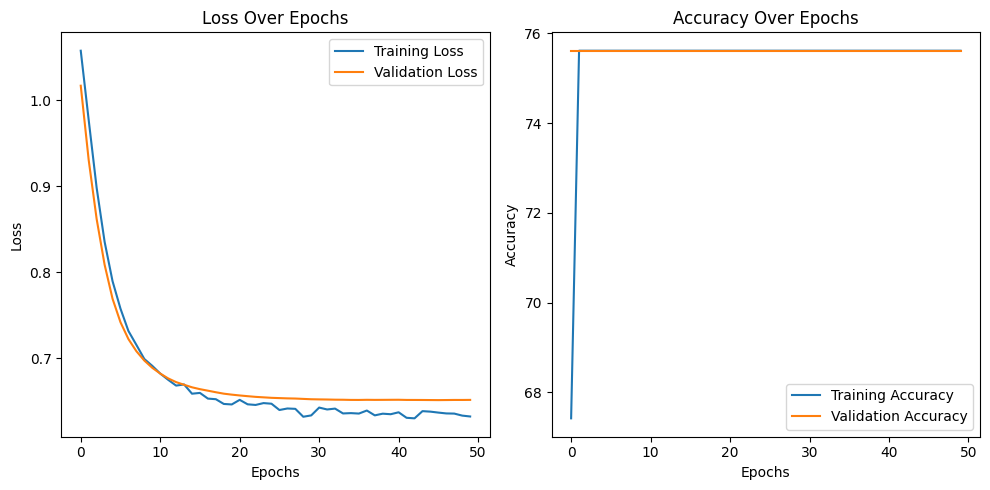

In [319]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()